# SMC Diagnostics  

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-white')

## N-Dimensional Gaussian mixture

In [3]:
dims = [i for i in range(20, 110, 20)]

stdev = 0.1
w1 = 0.1
w2 = (1 - w1)

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * pt.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * pt.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([pt.log(w1) + log_like1, pt.log(w2) + log_like2])

In [5]:
idatas_gauss = {
    "20": {}, "40": {}, "60": {},
    "80": {}, "100": {},
}

In [6]:
for n in dims:
    mu1 = np.ones(n) * (1. / 2)
    mu2 = -mu1
    sigma = np.power(stdev, 2) * np.eye(n)
    isigma = np.linalg.inv(sigma)
    logdsigma = np.linalg.slogdet(sigma)[1]
    # Model
    with pm.Model() as gaussians:
        X = pm.Uniform('X',
                       shape=n,
                       lower=-2. * np.ones_like(mu1),
                       upper=2. * np.ones_like(mu1),
                       initval=-1. * np.ones_like(mu1))
        llk = pm.Potential('llk', two_gaussians(X))

        idata = pm.sample_smc(5000, chains=4)
        idatas_gauss[str(n)] = idata

Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


Initializing SMC sampler...
Sampling 4 chains in 3 jobs


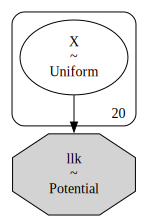

In [7]:
pm.model_to_graphviz(gaussians)

In [7]:
for n in dims:
    idata = idatas_gauss[str(n)]
    print(idata.sample_stats._t_sampling)

109.17040586471558
187.5045301914215
258.8523762226105
343.2831380367279
1014.467579126358


0.09595

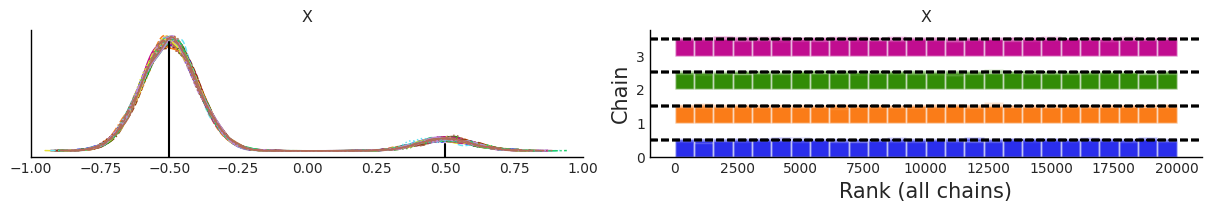

In [8]:
# Agregar loop
ax = az.plot_trace(idata_gauss, compact=True, kind="rank_bars")
ax[0, 0].axvline(-0.5, 0, .9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
ax[0, 0].set_xlim(-1, 1)
np.mean(idata_gauss.posterior["X"] > 0).item()

# Compute error score  

For mixture of two D-dimensional Gaussians model, we evaluate the agreement between the SMC samples and the true posterior using the following error score:
  
  
\begin{equation}
 \sqrt{\frac{1}{N} \sum_n^N [(v_s-\mu_0) * w_0 +  (v_s-\mu_1) * w_1]^2} + \lvert (b - b^\prime) \rvert
\label{eq:rmsd_w_wang}
\end{equation}
  
  
The first term is the weighted root mean squared deviation (RMSD) computed from $N$ posterior draws, where $\mu_i$ and $w_i$ are the true mean and weight. The second term $b$ is the Wang bimodality index \cite{Wang2009} computed from the samples and $b^\prime$ is the true value. 

The Wang bimodality index characterizes the degree of bimodality of a distribution and is calculated as:

\begin{equation}
    b = \frac{\lvert \mu_0 - \mu_1 \rvert}{\sigma}\sqrt{w_0(1-w_0)}
\end{equation}

where $\mu_i$ are the means of each mode and $w_i$ is the relative weight of each Gaussian. For simplicity in this work we assume $\sigma=1$.

In [9]:
# Wang bimodality index True Value
BI = abs(mu1 - mu2) * (w1*(1-w1))**0.5
posterior = idata_gauss.posterior
error_score_list = []

for chain in posterior["chain"]:
    for dimension in posterior["X_dim_0"]:
        v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
        above_zero = v > 0
        below_zero = v < 0
        w1_ = np.mean(below_zero)
        if np.any(above_zero) and np.any(below_zero):
            BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w1_*(1-w1_))**0.5
        else:
            BI_ = 0
        error_score = (np.mean(((v-mu1[0]) * w1 + (v-mu2[0]) * w2)**2))**0.5 + abs(BI - BI_)
        error_score_list.append(error_score)

np.mean(error_score_list), np.std(error_score_list)

(0.3165714817044464, 0.00035900873870647936)

## ESS and $\hat{R}$

In [19]:
print(az.ess(idata_gauss)["X"].values)

[15726.27347298 16598.34811004 15258.34975222 15965.16526622
 15866.32499871 16235.3563152  14320.87980969 14591.66126269
 15810.76582809 16125.72736753 14918.69119233 14945.87650551
 15869.82537358 14747.70585944 14351.95281118 15562.12230525
 15684.26519149 14982.24375365 15446.15442404 15064.84773843]


In [20]:
print(az.rhat(idata_gauss)["X"].values)

[1.00027234 0.99997724 1.00001385 1.00015032 1.0002193  1.00020893
 1.0003872  1.00030936 1.00001061 1.00017091 1.00043158 1.00034418
 0.99990036 1.0002475  1.00037753 1.0002897  1.00032822 1.00032714
 1.00011665 1.00037217]


## Coal mining disasters

For this model we may use NUTS as a "gold-standard"

In [10]:
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3,
                           0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1,
                           1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1,
                           0, 2, 3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2,
                           0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                           1, 0, 1])

years = np.arange(1851, 1962)

In [11]:
with pm.Model() as mining:
    # Prior for the switch-point 
    sp = pm.DiscreteUniform('sp', lower=years.min(), upper=years.max())

    # Priors for the rate before (t_0) and after (t_1)
    t_0 = pm.Exponential('t_0', 1)
    t_1 = pm.Exponential('t_1', 1)

    # We assign the rate according to the sp,
    rate = pm.Deterministic("rate", pm.math.switch(sp >= years, t_0, t_1))

    # Likelihood
    acc = pm.Poisson('acc', rate, observed=disaster_data)
    
    # We compute the posterior
    idata = pm.sample_smc(chains=4)

/home/pablo/anaconda3/envs/smc/lib/python3.9/site-packages/pymc/model.py:1379: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/home/pablo/anaconda3/envs/smc/lib/python3.9/site-packages/pymc/model.py:1402: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing SMC sampler...
Sampling 4 chains in 3 jobs


In [12]:
idata.sample_stats._t_sampling

7.667969226837158

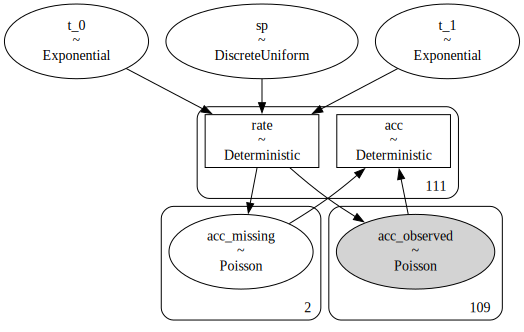

In [13]:
pm.model_to_graphviz(mining)

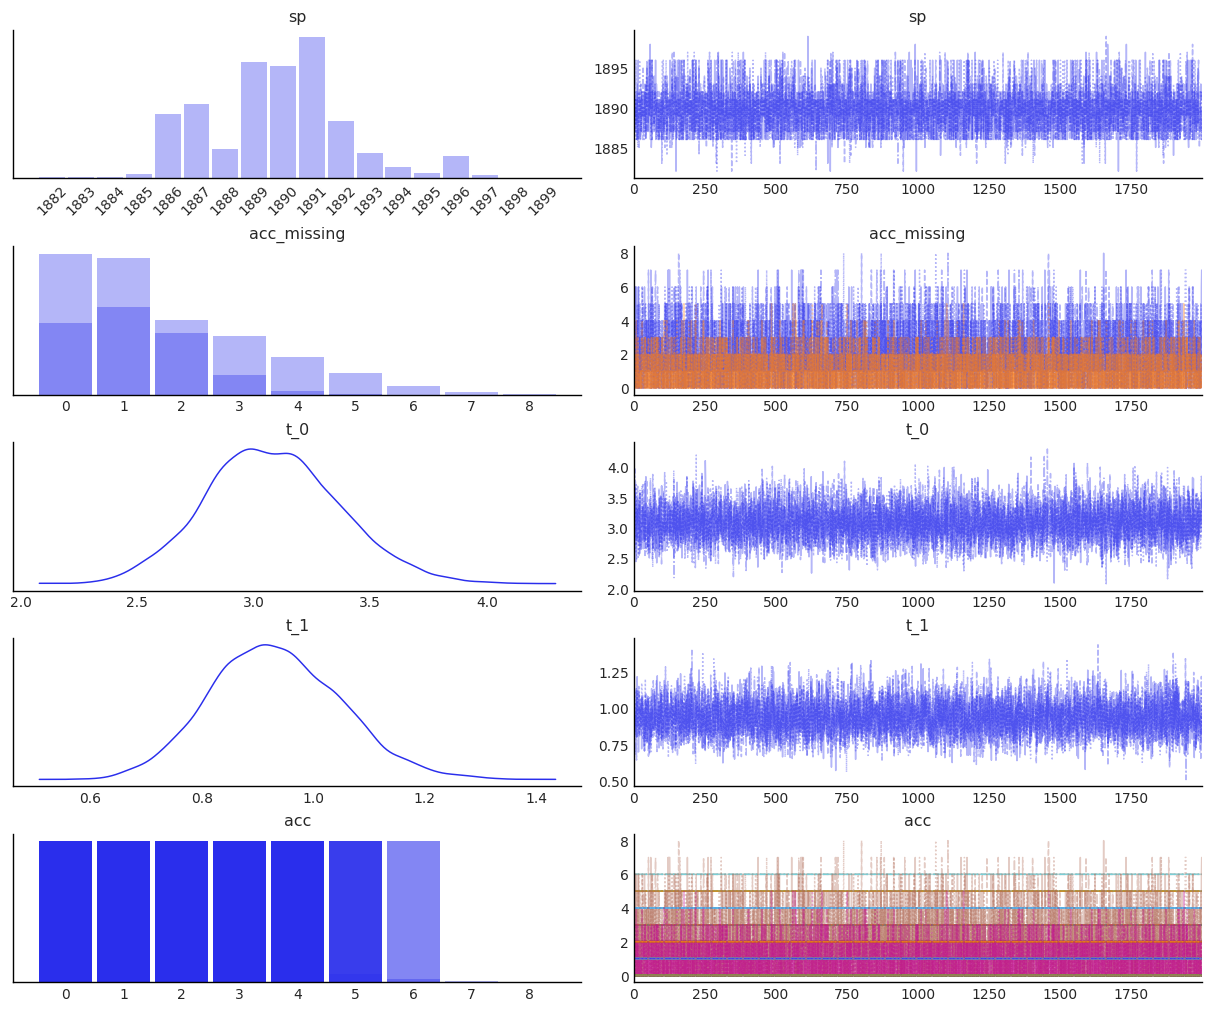

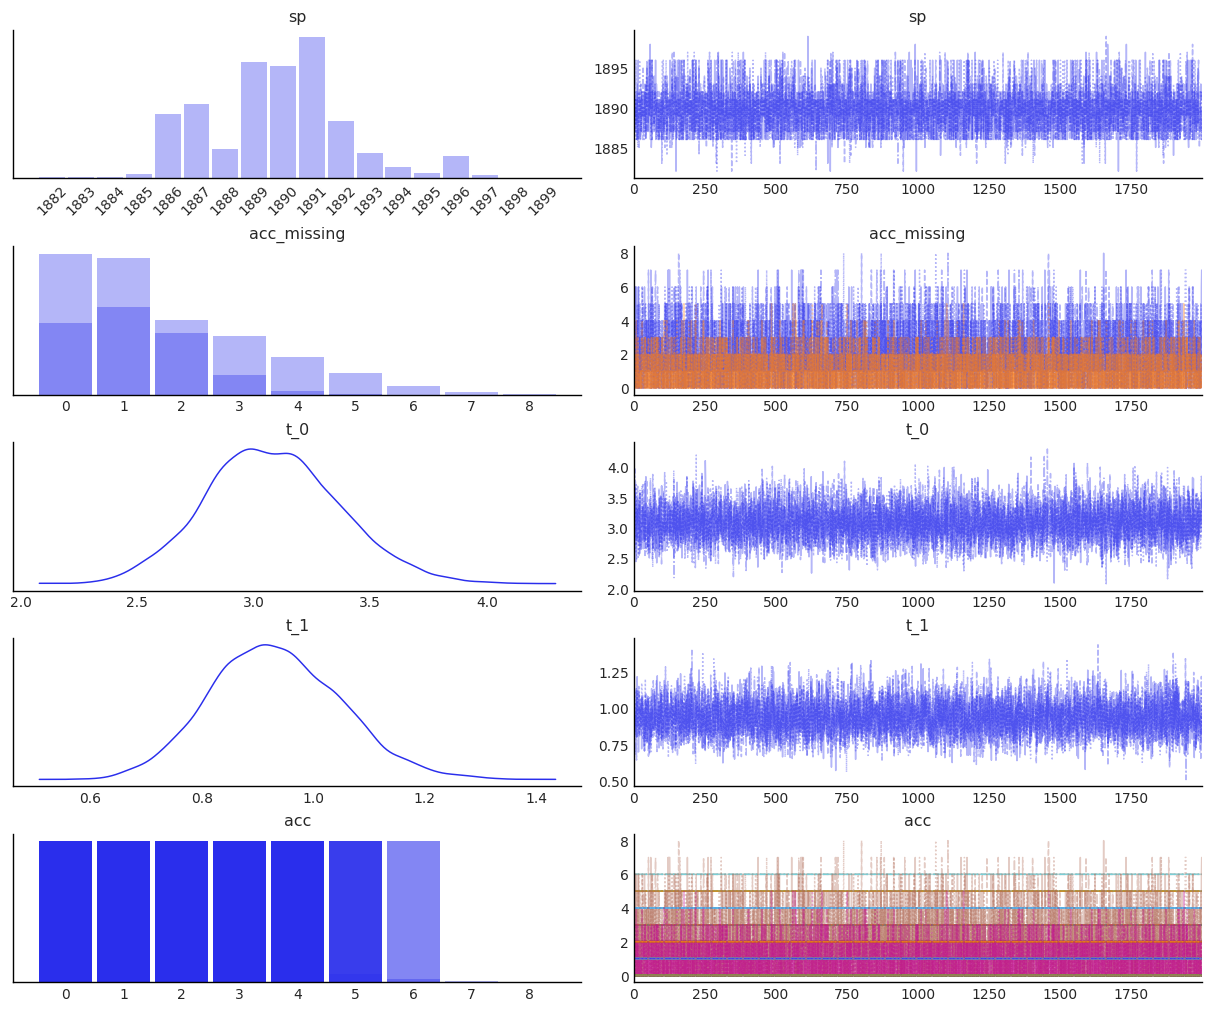

In [14]:
ax = az.plot_trace(idata, var_names=["~rate"], combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [15]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [16]:
data.head()

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


In [17]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sigma=5)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=5)
    sigma_b = pm.HalfNormal('sigma_b', 5)
     
    a_offset = pm.Normal('a_offset', mu=0, sigma=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sigma=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
 
    eps = pm.HalfNormal('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal('radon_like', mu=radon_est, sigma=eps, observed=data.log_radon)
    
    idata_nuts = pm.sample(2000)
    idata_smc_M = pm.sample_smc(5000, kernel=pm.smc.kernels.MH, chains=4)
    idata_smc_I = pm.sample_smc(5000, kernel=pm.smc.kernels.IMH, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a_offset, b_offset, eps]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing SMC sampler...
Sampling 4 chains in 3 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 4 chains in 3 jobs


In [18]:
idata_smc_M.sample_stats._t_sampling, idata_smc_I.sample_stats._t_sampling

(111.46998596191406, 108.31520819664001)

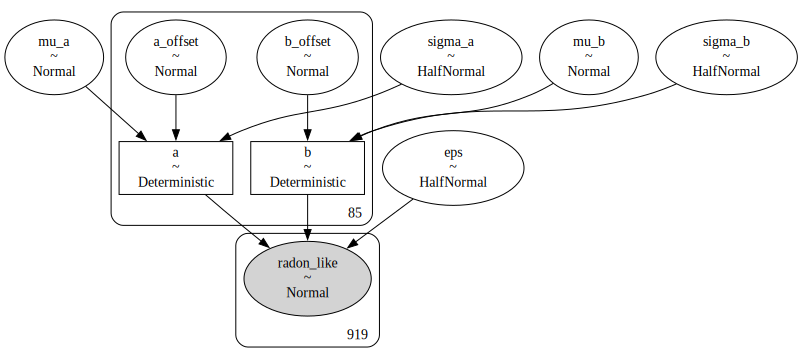

In [19]:
pm.model_to_graphviz(hierarchical_model_non_centered)

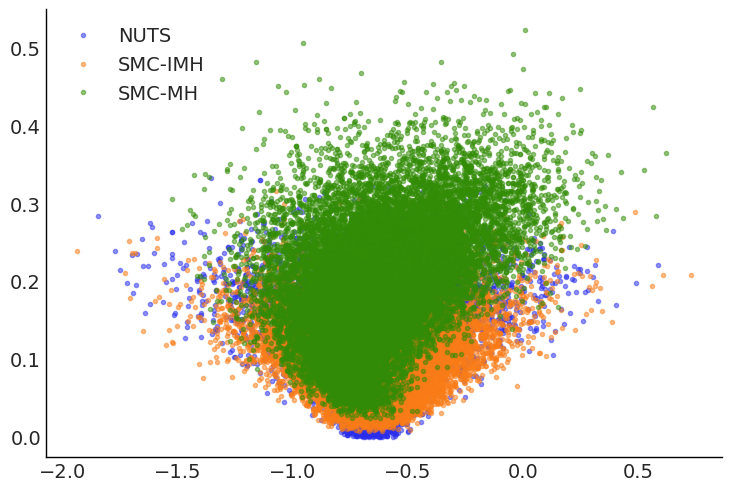

In [20]:
nuts_posterior = idata_nuts.posterior.stack(samples=("chain", "draw"))
smc_I_posterior = idata_smc_I.posterior.stack(samples=("chain", "draw"))
smc_M_posterior = idata_smc_M.posterior.stack(samples=("chain", "draw"))

plt.plot(nuts_posterior["b"].isel(b_dim_0=75),
         nuts_posterior["sigma_b"], 
         '.C0', alpha=0.5,
         label="NUTS")
plt.plot(smc_I_posterior["b"].isel(b_dim_0=75),
         smc_I_posterior["sigma_b"],
         '.C1', alpha=0.5,
         label="SMC-IMH")
plt.plot(smc_M_posterior["b"].isel(b_dim_0=75), 
         smc_M_posterior["sigma_b"],
         '.C2', alpha=0.5,
         label="SMC-MH")

plt.legend();